In [1]:
import pymysql
import pandas as pd

In [2]:
db_config = {
    "host": "127.0.0.1",  # Change to your database host
    "user": "root",       # Change to your database username
    "password": "5440",  # Change to your database password
    "database": "sales"  # Change to your database name
}

In [3]:
queries = [

# Query 1: Monthly sales with yearly total
    
    """

WITH monthly_sales AS (
    SELECT
        sd.category,
        DATE_FORMAT(od.order_date, '%Y-%m') AS sales_month,
        SUM(od.qty_ordered) AS total_sales
    FROM
        order_detail od
    JOIN
        sku_detail sd ON od.sku_id = sd.id
    WHERE
        od.is_valid = 1
        AND YEAR(od.order_date) = 2022
    GROUP BY
        sd.category,
        DATE_FORMAT(od.order_date, '%Y-%m')
),
yearly_total AS (
    SELECT
        category,
        SUM(total_sales) AS total_sales_2022
    FROM monthly_sales
    GROUP BY category
)
SELECT
    ms.category,
    ms.sales_month,
    ms.total_sales,
    yt.total_sales_2022
FROM
    monthly_sales ms
JOIN
    yearly_total yt ON ms.category = yt.category
ORDER BY
    yt.total_sales_2022 DESC,
    ms.category,
    ms.sales_month;

""",

# Query 2: Weekday vs weekend 

"""

WITH daily_sales AS (
    SELECT
        DATE(order_date) AS sales_date,
        MONTH(order_date) AS month_id,
        MONTHNAME(order_date) AS month_name,
        CASE
            WHEN DAYOFWEEK(order_date) IN (1, 7) THEN 'Weekend'
            ELSE 'Weekday'
        END AS day_type,
        SUM(before_discount) AS total_sales
    FROM order_detail
    WHERE
        is_valid = 1
        AND order_date BETWEEN '2022-10-01' AND '2022-12-31'
    GROUP BY
        DATE(order_date),
        MONTH(order_date),
        MONTHNAME(order_date),
        CASE
            WHEN DAYOFWEEK(order_date) IN (1, 7) THEN 'Weekend'
            ELSE 'Weekday'
        END
),

monthly_avg AS (
    SELECT
        month_name,
        day_type,
        ROUND(AVG(total_sales), 2) AS avg_daily_sales
    FROM daily_sales
    GROUP BY
        month_name, day_type
),

overall_avg AS (
    SELECT
        'Overall' AS month_name,
        day_type,
        ROUND(AVG(total_sales), 2) AS avg_daily_sales
    FROM daily_sales
    GROUP BY day_type
)

SELECT * FROM monthly_avg
UNION ALL
SELECT * FROM overall_avg
ORDER BY
    FIELD(month_name, 'October', 'November', 'December', 'Overall'),
    FIELD(day_type, 'Weekday', 'Weekend');


""",


# query 3: net profit  

"""
SELECT
    sd.category,
    YEAR(od.order_date) AS year,
    ROUND(SUM(od.after_discount - sd.cogs), 2) AS total_net_profit
FROM
    order_detail od
JOIN
    sku_detail sd ON od.sku_id = sd.id
WHERE
    od.is_valid = 1
GROUP BY
    sd.category,
    YEAR(od.order_date)
ORDER BY
    total_net_profit DESC;

""",

# Query4:Discount impact

"""
SELECT
    sd.category,
    ROUND(SUM(od.before_discount), 2) AS total_before_discount,
    ROUND(SUM(od.after_discount), 2) AS total_after_discount,
    ROUND(SUM(od.before_discount - od.after_discount), 2) AS discount_impact
FROM
    order_detail od
JOIN
    sku_detail sd ON od.sku_id = sd.id
WHERE
    od.is_valid = 1
GROUP BY
    sd.category
ORDER BY
    discount_impact DESC;
"""
]

In [4]:
from IPython.display import display

In [5]:
try:
    connection = pymysql.connect(**db_config)
    print("Database connection successful!")

    for i, query in enumerate(queries, start=1):
        print(f"\n--- Running Query {i} ---")
        df = pd.read_sql(query, connection)
        display(df)  # If using Jupyter; use print(df.head()) in terminal scripts

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    if connection:
        connection.close()
        print("Database connection closed.")

Database connection successful!

--- Running Query 1 ---


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\3248947010.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,category,sales_month,total_sales,total_sales_2022
0,Mobiles & Tablets,2022-01,21.0,1153.0
1,Mobiles & Tablets,2022-02,11.0,1153.0
2,Mobiles & Tablets,2022-03,17.0,1153.0
3,Mobiles & Tablets,2022-04,12.0,1153.0
4,Mobiles & Tablets,2022-05,11.0,1153.0
...,...,...,...,...
175,Appliances,2022-08,19.0,146.0
176,Appliances,2022-09,4.0,146.0
177,Appliances,2022-10,5.0,146.0
178,Appliances,2022-11,3.0,146.0



--- Running Query 2 ---


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\3248947010.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,month_name,day_type,avg_daily_sales
0,October,Weekday,7793912.40
1,October,Weekend,5708340.67
2,November,Weekday,6204666.00
3,November,Weekend,5774045.00
4,December,Weekday,8411063.33
5,December,Weekend,4105994.00
6,Overall,Weekday,7450819.88
7,Overall,Weekend,5269300.00



--- Running Query 3 ---


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\3248947010.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,category,year,total_net_profit
0,Mobiles & Tablets,2022,6.672866e+08
1,Mobiles & Tablets,2021,1.618607e+08
2,Entertainment,2022,1.288542e+08
3,Appliances,2022,8.781125e+07
4,Computing,2022,6.168569e+07
5,Appliances,2021,6.012956e+07
6,Entertainment,2021,5.004097e+07
7,Computing,2021,4.838325e+07
8,Women Fashion,2022,3.986992e+07
9,Men Fashion,2022,3.212228e+07



--- Running Query 4 ---


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\3248947010.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,category,total_before_discount,total_after_discount,discount_impact
0,Appliances,5.318213e+08,5.281342e+08,3687089.00
1,Others,6.418205e+07,6.109086e+07,3091184.23
2,Superstore,6.375135e+07,6.125849e+07,2492856.24
3,Computing,3.867463e+08,3.852871e+08,1459233.62
4,Entertainment,5.145870e+08,5.135200e+08,1067023.00
5,Health & Sports,8.597891e+07,8.517679e+07,802116.81
6,Mobiles & Tablets,1.284221e+09,1.283432e+09,788800.00
7,Women Fashion,1.749038e+08,1.742821e+08,621737.38
8,Home & Living,1.235380e+08,1.230441e+08,493904.80
9,Men Fashion,1.915952e+08,1.912074e+08,387817.00


Database connection closed.


In [6]:
import os

In [7]:
# Database connection details
db_config = {
    "host": "127.0.0.1", 
    "user": "root",      
    "password": "5440",  
    "database": "sales"  
}

In [8]:
# Folder path to save CSV files
output_folder = r"C:\Users\This pc\Downloads\looker project"  
os.makedirs(output_folder, exist_ok=True)  

In [9]:
tables = ["order_detail", "sku_detail", "payment_detail","customer_detail"]  

In [10]:
try:
    # Connect to the database
    connection = pymysql.connect(**db_config)
    print("Database connection successful!")

    for table in tables:
        print(f"Exporting table: {table}")
        
        # SQL query to fetch all data from the table
        query = f"SELECT * FROM {table};"
        
        # Read table data into a DataFrame
        df = pd.read_sql(query, connection)
        
        # Save the DataFrame to a CSV file
        output_file = os.path.join(output_folder, f"{table}.csv")
        df.to_csv(output_file, index=False)
        
        print(f"Table {table} exported successfully to {output_file}.")

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    if connection:
        connection.close()
        print("Database connection closed.")

Database connection successful!
Exporting table: order_detail


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\1590211234.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Table order_detail exported successfully to C:\Users\This pc\Downloads\looker project\order_detail.csv.
Exporting table: sku_detail
Table sku_detail exported successfully to C:\Users\This pc\Downloads\looker project\sku_detail.csv.
Exporting table: payment_detail
Table payment_detail exported successfully to C:\Users\This pc\Downloads\looker project\payment_detail.csv.
Exporting table: customer_detail
Table customer_detail exported successfully to C:\Users\This pc\Downloads\looker project\customer_detail.csv.
Database connection closed.


In [11]:
df_od = pd.read_csv("desktop/order_detail.csv")
df_sd = pd.read_csv("desktop/sku_detail.csv")
df_pd = pd.read_csv("desktop/payment_detail.csv")
df_cd = pd.read_csv("desktop/customer_detail.csv")

In [12]:
#Merge the dataframes
# Before merge we need to rename column in order to avoid duplicate column value
# So the key column will be excluded when joined
df_sd.rename(columns={'id':'sku_id'}, inplace=True)
df_cd.rename(columns={'id':'customer_id'}, inplace=True)
df_pd.rename(columns={'id':'payment_id'}, inplace=True)

In [13]:
# Merge the dataframes using left join
df = pd.DataFrame(df_od\
                  # Merge order_detail with sku_detail on column sku_id
                  .merge(df_sd, how='left', on='sku_id')\
                  # Merge the result to customer_detail on column customer_id
                  .merge(df_cd, how='left', on='customer_id')\
                  # Merge the result to payment_detail on column payment_id
                  .merge(df_pd, how='left', on='payment_id')
                  )

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5764 non-null   object 
 1   customer_id      5764 non-null   object 
 2   order_date       5764 non-null   object 
 3   sku_id           5764 non-null   object 
 4   price            5764 non-null   int64  
 5   qty_ordered      5764 non-null   int64  
 6   before_discount  5764 non-null   float64
 7   discount_amount  5764 non-null   float64
 8   after_discount   5764 non-null   float64
 9   is_gross         5764 non-null   int64  
 10  is_valid         5764 non-null   int64  
 11  is_net           5764 non-null   int64  
 12  payment_id       5764 non-null   int64  
 13  sku_name         5764 non-null   object 
 14  base_price       5764 non-null   float64
 15  cogs             5764 non-null   float64
 16  category         5764 non-null   object 
 17  registered_dat

In [15]:
print(df_pd.columns)

Index(['payment_id', 'payment_method'], dtype='object')


In [16]:
print(df_od.columns)

Index(['id', 'customer_id', 'order_date', 'sku_id', 'price', 'qty_ordered',
       'before_discount', 'discount_amount', 'after_discount', 'is_gross',
       'is_valid', 'is_net', 'payment_id'],
      dtype='object')


In [17]:
# Ensure both columns have the same data type before merging
df_pd['payment_id'] = df_pd['payment_id'].astype(str)  # Convert to string
df_od['id'] = df_od['id'].astype(str)                  # Convert to string

# Merge order_detail with payment_detail without renaming columns
df_sample = pd.merge(df_pd, df_od, how='left', left_on='payment_id', right_on='id')

# Display info about the resulting DataFrame
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payment_id_x     16 non-null     object 
 1   payment_method   16 non-null     object 
 2   id               0 non-null      object 
 3   customer_id      0 non-null      object 
 4   order_date       0 non-null      object 
 5   sku_id           0 non-null      object 
 6   price            0 non-null      float64
 7   qty_ordered      0 non-null      float64
 8   before_discount  0 non-null      float64
 9   discount_amount  0 non-null      float64
 10  after_discount   0 non-null      float64
 11  is_gross         0 non-null      float64
 12  is_valid         0 non-null      float64
 13  is_net           0 non-null      float64
 14  payment_id_y     0 non-null      float64
dtypes: float64(9), object(6)
memory usage: 2.0+ KB


In [18]:
# change columns to datetime format using for loop
# use pandas.to_datetime to convert
for x in ['order_date', 'registered_date']:
  df[x] = pd.to_datetime(df[x])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               5764 non-null   object        
 1   customer_id      5764 non-null   object        
 2   order_date       5764 non-null   datetime64[ns]
 3   sku_id           5764 non-null   object        
 4   price            5764 non-null   int64         
 5   qty_ordered      5764 non-null   int64         
 6   before_discount  5764 non-null   float64       
 7   discount_amount  5764 non-null   float64       
 8   after_discount   5764 non-null   float64       
 9   is_gross         5764 non-null   int64         
 10  is_valid         5764 non-null   int64         
 11  is_net           5764 non-null   int64         
 12  payment_id       5764 non-null   int64         
 13  sku_name         5764 non-null   object        
 14  base_price       5764 non-null   float64

C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\2016510988.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


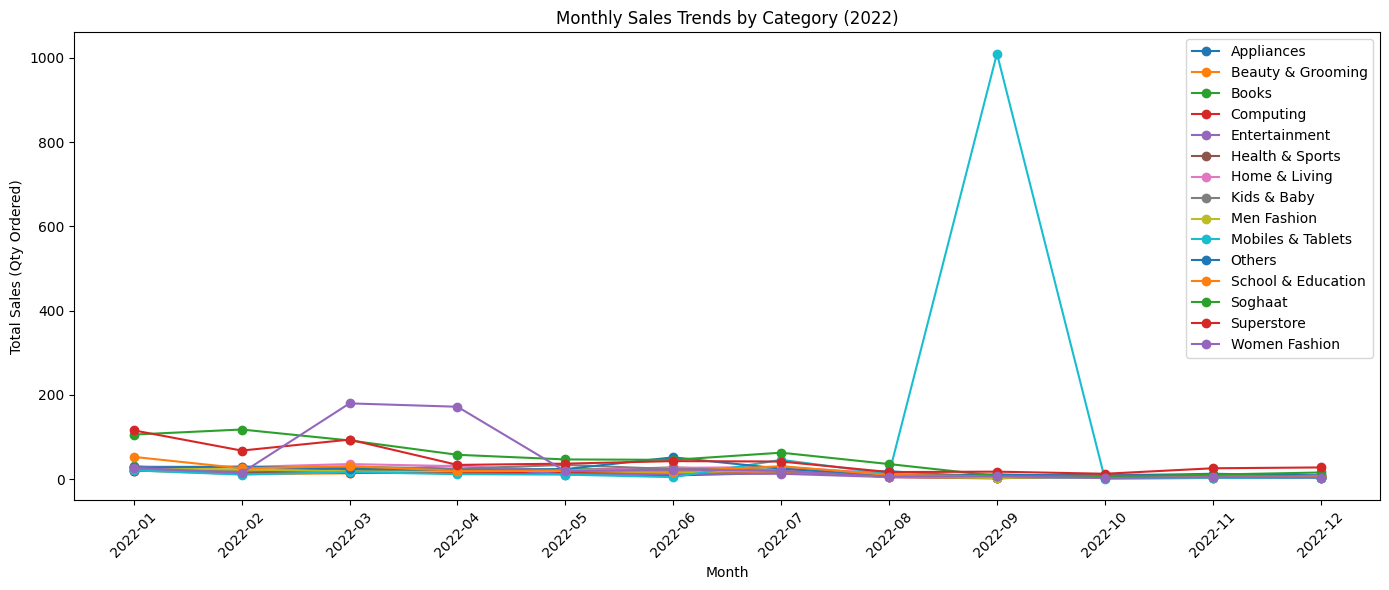

In [19]:
#question 1 
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

# DB Connection
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "5440",
    "database": "sales"
}

query = """
SELECT
    sd.category,
    DATE_FORMAT(od.order_date, '%Y-%m') AS sales_month,
    SUM(od.qty_ordered) AS total_sales
FROM
    order_detail od
JOIN
    sku_detail sd ON od.sku_id = sd.id
WHERE
    od.is_valid = 1
    AND YEAR(od.order_date) = 2022
GROUP BY
    sd.category,
    DATE_FORMAT(od.order_date, '%Y-%m')
ORDER BY
    sd.category, sales_month;
"""

# Fetch data
conn = pymysql.connect(**db_config)
df = pd.read_sql(query, conn)
conn.close()

# Pivot for plotting
pivot_df = df.pivot(index='sales_month', columns='category', values='total_sales').fillna(0)

# Plotting
plt.figure(figsize=(14, 6))
for category in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[category], marker='o', label=category)

plt.title("Monthly Sales Trends by Category (2022)")
plt.xlabel("Month")
plt.ylabel("Total Sales (Qty Ordered)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [20]:
# insights on highest sales growth
yearly_sales = df.groupby("category")["total_sales"].sum().sort_values(ascending=False)
print("Total Sales in 2022 by Category:\n")
print(yearly_sales)

# Optional: Compute % growth from Jan to Dec
start_month = pivot_df.iloc[0]
end_month = pivot_df.iloc[-1]
growth = ((end_month - start_month) / start_month) * 100
print("\nPercentage Growth from Jan to Dec:\n")
print(growth.sort_values(ascending=False))


Total Sales in 2022 by Category:

category
Mobiles & Tablets     1153.0
Soghaat                607.0
Superstore             536.0
Women Fashion          481.0
Others                 254.0
Home & Living          249.0
School & Education     235.0
Kids & Baby            224.0
Health & Sports        197.0
Books                  195.0
Men Fashion            173.0
Beauty & Grooming      152.0
Computing              151.0
Entertainment          149.0
Appliances             146.0
Name: total_sales, dtype: float64

Percentage Growth from Jan to Dec:

category
Beauty & Grooming    -61.904762
Others               -67.857143
Home & Living        -70.000000
Computing            -70.000000
Kids & Baby          -71.428571
Men Fashion          -74.074074
Superstore           -75.862069
Entertainment        -77.272727
Health & Sports      -79.310345
Soghaat              -84.905660
Appliances           -85.000000
Women Fashion        -85.185185
Mobiles & Tablets    -85.714286
School & Education   -86.7

C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\3019744303.py:70: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_weekdays_weekends = pd.read_sql(query, connection)


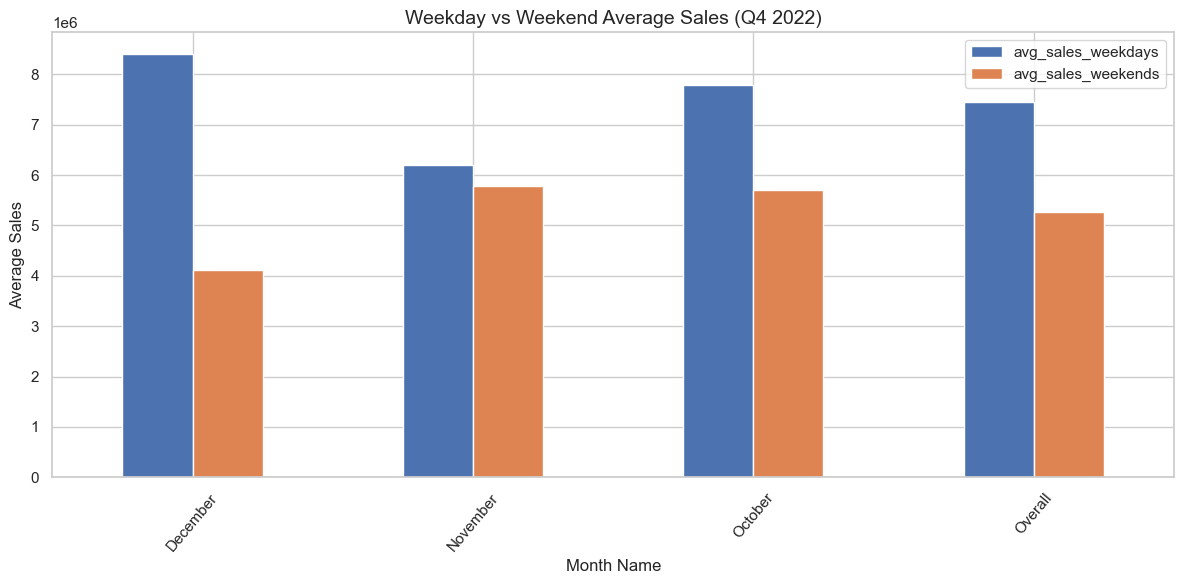

In [21]:
#question 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql

# 1. Reconnect to the database (fix broken connection)
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "5440",
    "database": "sales"
}
connection = pymysql.connect(**db_config)

# 2. Paste actual SQL query string
query = """
WITH daily_sales AS (
    SELECT
        DATE(order_date) AS sales_date,
        MONTH(order_date) AS month_id,
        MONTHNAME(order_date) AS month_name,
        CASE
            WHEN DAYOFWEEK(order_date) IN (1, 7) THEN 'Weekend'
            ELSE 'Weekday'
        END AS day_type,
        SUM(before_discount) AS total_sales
    FROM order_detail
    WHERE
        is_valid = 1
        AND order_date BETWEEN '2022-10-01' AND '2022-12-31'
    GROUP BY
        DATE(order_date),
        MONTH(order_date),
        MONTHNAME(order_date),
        CASE
            WHEN DAYOFWEEK(order_date) IN (1, 7) THEN 'Weekend'
            ELSE 'Weekday'
        END
),

monthly_avg AS (
    SELECT
        month_name,
        day_type,
        ROUND(AVG(total_sales), 2) AS avg_daily_sales
    FROM daily_sales
    GROUP BY
        month_name, day_type
),

overall_avg AS (
    SELECT
        'Overall' AS month_name,
        day_type,
        ROUND(AVG(total_sales), 2) AS avg_daily_sales
    FROM daily_sales
    GROUP BY day_type
)

SELECT * FROM monthly_avg
UNION ALL
SELECT * FROM overall_avg
ORDER BY
    FIELD(month_name, 'October', 'November', 'December', 'Overall'),
    FIELD(day_type, 'Weekday', 'Weekend');
"""

# 3. Execute and load into DataFrame
data_weekdays_weekends = pd.read_sql(query, connection)

# 4. Pivot the data
pivot_df = data_weekdays_weekends.pivot(index='month_name', columns='day_type', values='avg_daily_sales').reset_index()
pivot_df.columns.name = None
pivot_df.rename(columns={
    'Weekday': 'avg_sales_weekdays',
    'Weekend': 'avg_sales_weekends',
    'month_name': 'Period'
}, inplace=True)

# 5. Plot
sns.set(style="whitegrid")
pivot_df.plot(x='Period',
              y=['avg_sales_weekdays', 'avg_sales_weekends'],
              kind='bar',
              xlabel='Month Name',
              ylabel='Average Sales',
              figsize=(12, 6),
              rot=50,
              grid=True)

plt.title("Weekday vs Weekend Average Sales (Q4 2022)", fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 6. Close connection
connection.close()


In [22]:
# Specify the file path and name
file_path = r"C:\Users\This pc\Desktop\Looker project\finaldataset5.csv"  # Update with your desired folder path

# Save to CSV
df.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\This pc\Desktop\Looker project\finaldataset5.csv


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\2062835150.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


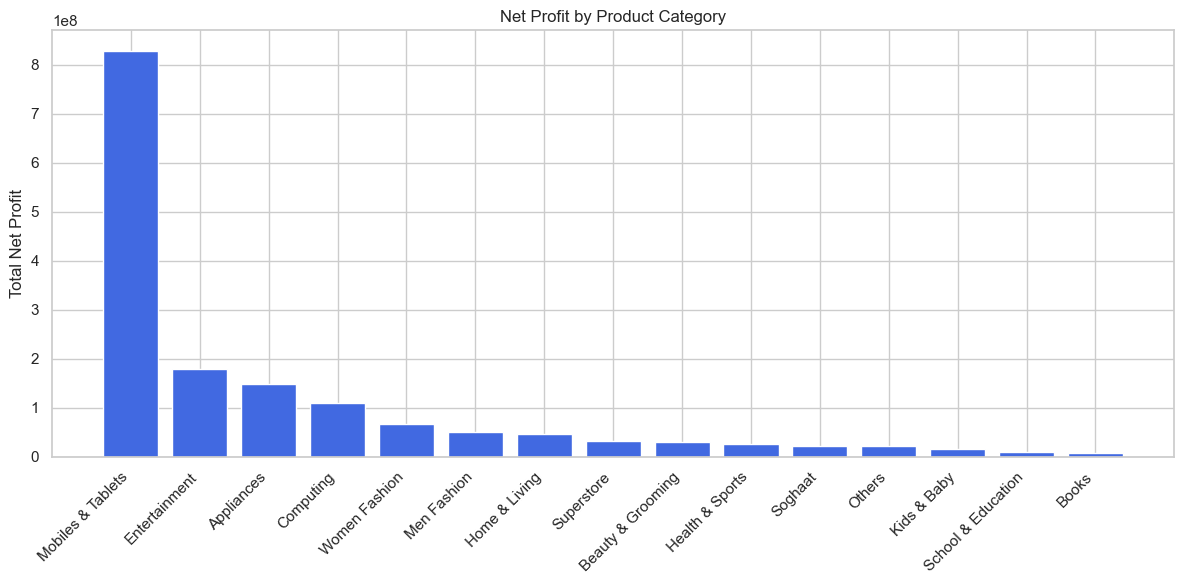

In [23]:
# question 3
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "5440",
    "database": "sales"
}

# SQL query
query = """
SELECT
    sd.category,
    ROUND(SUM(od.after_discount - sd.cogs), 2) AS total_net_profit
FROM
    order_detail od
JOIN
    sku_detail sd ON od.sku_id = sd.id
WHERE
    od.is_valid = 1
GROUP BY
    sd.category
ORDER BY
    total_net_profit DESC;
"""

#Fetch data
connection = pymysql.connect(**db_config)
df = pd.read_sql(query, connection)
connection.close()

# Step 4: Vertical Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(df['category'], df['total_net_profit'], color='royalblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Net Profit")
plt.title("Net Profit by Product Category")
plt.tight_layout()
plt.show()


C:\Users\This pc\AppData\Local\Temp\ipykernel_16644\2265249165.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


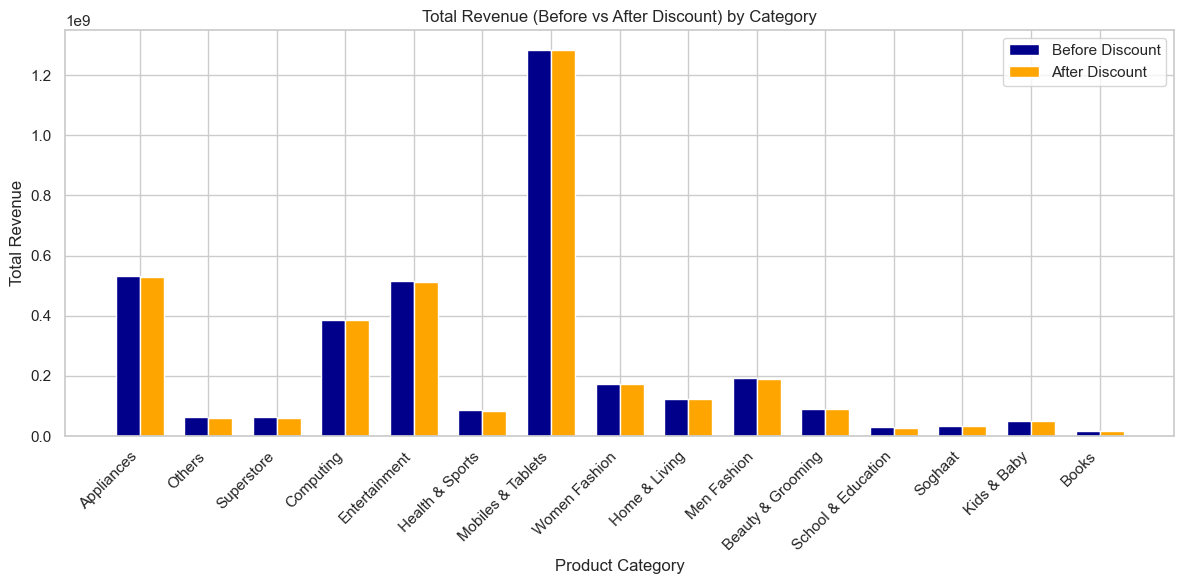

In [24]:
# quwstion 4
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: DB config
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "5440",
    "database": "sales"
}

# Step 2: SQL query
query = """
SELECT
    sd.category,
    ROUND(SUM(od.before_discount), 2) AS total_before_discount,
    ROUND(SUM(od.after_discount), 2) AS total_after_discount,
    ROUND(SUM(od.before_discount - od.after_discount), 2) AS discount_impact
FROM
    order_detail od
JOIN
    sku_detail sd ON od.sku_id = sd.id
WHERE
    od.is_valid = 1
GROUP BY
    sd.category
ORDER BY
    discount_impact DESC;
"""

# Step 3: Fetch data
connection = pymysql.connect(**db_config)
df = pd.read_sql(query, connection)
connection.close()

# Step 4: Grouped Bar Chart
categories = df['category']
before = df['total_before_discount']
after = df['total_after_discount']

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, before, width, label='Before Discount', color='darkblue')
plt.bar(x + width/2, after, width, label='After Discount', color='orange')

plt.xlabel("Product Category")
plt.ylabel("Total Revenue")
plt.title("Total Revenue (Before vs After Discount) by Category")
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Specify the file path and name
file_path = r"C:\Users\This pc\Desktop\Looker project\finaldataset.csv"  # Update with your desired folder path

# Save to CSV
df.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\This pc\Desktop\Looker project\finaldataset.csv
